In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

In [77]:
heart = pd.read_csv('Resources/heart.csv')

In [78]:
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [79]:
# --- Print Dataset Info ---
print('Dataset Info:')
print('Total Rows:'+'\033[1m', heart.shape[0])
print('\033[0m'+'Total Columns:'+'\033[1m', heart.shape[1])
print('\n')

# --- Print Dataset Detail ---
print('Dataset Details:')
heart.info(memory_usage = False)

Dataset Info:
Total Rows: 918
Total Columns: 12


Dataset Details:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)

In [80]:
#Make sex into int
heart['Sex'] = heart['Sex'].map({'M':0,
                               'F':1})

print('Total Sex by Gender:')
heart.Sex.value_counts(dropna=False)

Total Sex by Gender:


0    725
1    193
Name: Sex, dtype: int64

In [81]:
#Make ExerciseAngina into int
heart['ExerciseAngina'] = heart['ExerciseAngina'].map({'N': 0, 'Y': 1})
print('Total exercie by Gender:')
heart.ExerciseAngina.value_counts(dropna=False)

Total exercie by Gender:


0    547
1    371
Name: ExerciseAngina, dtype: int64

In [82]:
#Make chestpain into int
heart['ChestPainType'] = heart['ChestPainType'].map({"ASY": 0, "ATA": 1, "NAP": 2, "TA": 3})
print('ChestPainType:')
heart.ChestPainType.value_counts(dropna=False)

ChestPainType:


0    496
2    203
1    173
3     46
Name: ChestPainType, dtype: int64

In [83]:
#Make RestingECG into int
heart['RestingECG'] = heart['RestingECG'].map({"Normal": 0, "ST": 1, "LVH": 2})
print('Total RestingECG by type:')
heart.RestingECG.value_counts(dropna=False)

Total RestingECG by type:


0    552
2    188
1    178
Name: RestingECG, dtype: int64

In [84]:
#Make ST_Slope into int
heart['ST_Slope'] = heart['ST_Slope'].map({'Down': 0, 'Flat': 1, 'Up': 2})
print('Total ST_Slope by type:')
heart.ST_Slope.value_counts(dropna=False)

Total ST_Slope by type:


1    460
2    395
0     63
Name: ST_Slope, dtype: int64

In [85]:
# Dataset Detail 
print('Dataset Details:')
heart.info(memory_usage = False)

Dataset Details:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    int64  
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    int64  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    int64  
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(11)

In [86]:
# Creating Dummy Variables for ChestPainType, thal and slope ---
ChestPainType = pd.get_dummies(heart['ChestPainType'], prefix='ChestPainType')
RestingECG = pd.get_dummies(heart['RestingECG'], prefix='RestingECG')
ST_Slope = pd.get_dummies(heart['ST_Slope'], prefix='ST_Slope')

# --- Merge Dummy Variables to Main Data Frame ---
frames = [heart, ChestPainType, RestingECG, ST_Slope]
heart = pd.concat(frames, axis = 1)
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,...,ChestPainType_0,ChestPainType_1,ChestPainType_2,ChestPainType_3,RestingECG_0,RestingECG_1,RestingECG_2,ST_Slope_0,ST_Slope_1,ST_Slope_2
0,40,0,1,140,289,0,0,172,0,0.0,...,0,1,0,0,1,0,0,0,0,1
1,49,1,2,160,180,0,0,156,0,1.0,...,0,0,1,0,1,0,0,0,1,0
2,37,0,1,130,283,0,1,98,0,0.0,...,0,1,0,0,0,1,0,0,0,1
3,48,1,0,138,214,0,0,108,1,1.5,...,1,0,0,0,1,0,0,0,1,0
4,54,0,2,150,195,0,0,122,0,0.0,...,0,0,1,0,1,0,0,0,0,1


In [88]:
# Drop Unnecessary Variables
heart = heart.drop(columns = ['ChestPainType', 'RestingECG', 'ST_Slope'])
heart.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_0,ChestPainType_1,ChestPainType_2,ChestPainType_3,RestingECG_0,RestingECG_1,RestingECG_2,ST_Slope_0,ST_Slope_1,ST_Slope_2
0,40,0,140,289,0,172,0,0.0,0,0,1,0,0,1,0,0,0,0,1
1,49,1,160,180,0,156,0,1.0,1,0,0,1,0,1,0,0,0,1,0
2,37,0,130,283,0,98,0,0.0,0,0,1,0,0,0,1,0,0,0,1
3,48,1,138,214,0,108,1,1.5,1,1,0,0,0,1,0,0,0,1,0
4,54,0,150,195,0,122,0,0.0,0,0,0,1,0,1,0,0,0,0,1


In [89]:
# Seperating 
X = heart.drop(['HeartDisease'], axis=1)
y = heart['HeartDisease']


In [90]:
# Normalize to increase number of iterations
X = MinMaxScaler().fit_transform(X)

In [91]:
# --- Splitting Dataset into 80:20 ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [92]:
classifier = LogisticRegression()
classifier

LogisticRegression()

In [93]:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

LogisticRegression()

In [94]:
classifier.fit(X_train, y_train)
#from sklearn.feature_selection import RFE
#rfe = RFE(classifier, 10)             
#rfe = rfe.fit(X_train, y_train)

LogisticRegression()

In [95]:
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.8651226158038147
Testing Data Score: 0.8913043478260869


In [96]:
print("prediction based on your values!") 
age = input("Enter age:")

prediction based on your values!
Enter age:49


In [97]:
sex = input("Enter gender (male = 0 and female = 1):")

Enter gender (male = 0 and female = 1):1


In [98]:
ASY = input("Enter 1 if chest pain is ASY (otherwise enter 0):")

Enter 1 if chest pain is ASY (otherwise enter 0):0


In [99]:
ATA = input("Enter 1 if chest pain is ATA (otherwise enter 0):")

Enter 1 if chest pain is ATA (otherwise enter 0):0


In [100]:
NAP = input("Enter 1 if chest pain is NAP (otherwise enter 0):")

Enter 1 if chest pain is NAP (otherwise enter 0):1


In [101]:
TA = input("Enter 1 if chest pain is TA (otherwise enter 0):")

Enter 1 if chest pain is TA (otherwise enter 0):0


In [102]:
restingBP = input("Enter resting blood pressure:")

Enter resting blood pressure:160


In [103]:
cholesterol= input("Enter cholesterol:")

Enter cholesterol:180


In [104]:
fasting = input("Enter fasting blood sugar:")

Enter fasting blood sugar:0


In [105]:
normalECG = input("Enter 1 if resting ECG is normal (otherwise enter 0):")

Enter 1 if resting ECG is normal (otherwise enter 0):1


In [106]:
stECG = input("Enter 1 if resting ECG is ST (otherwise enter 0):")

Enter 1 if resting ECG is ST (otherwise enter 0):0


In [107]:
lvhECG = input("Enter 1 if resting ECG is LVH (otherwise enter 0):")

Enter 1 if resting ECG is LVH (otherwise enter 0):0


In [108]:
maxHR = input("Enter umax heart rate:")

Enter umax heart rate:156


In [109]:
exercise = input("Enter exercise induced angina (no= 0 or yes = 1):")

Enter exercise induced angina (no= 0 or yes = 1):0


In [110]:
oldpeak = input("Enter ST depression induced by exercise relative to rest:")

Enter ST depression induced by exercise relative to rest:1


In [111]:
down_slope = input("Enter 1 if slope of the peak exercise ST segment is down (otherwise enter 0):")

Enter 1 if slope of the peak exercise ST segment is down (otherwise enter 0):0


In [112]:
flat_slope = input("Enter 1 if slope of the peak exercise ST segment is flat (otherwise enter 0):")

Enter 1 if slope of the peak exercise ST segment is flat (otherwise enter 0):1


In [113]:
up_slope = input("Enter 1 if slope of the peak exercise ST segment is up (otherwise enter 0):")

Enter 1 if slope of the peak exercise ST segment is up (otherwise enter 0):0


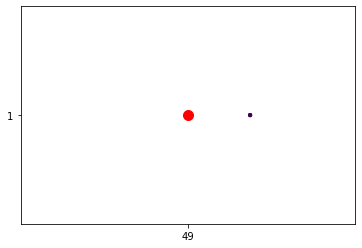

In [114]:
# Generate a new data point (the red circle)
import numpy as np
new_data = np.array([[age, sex, ASY, ATA, NAP, TA, restingBP, cholesterol, fasting, normalECG, stECG, lvhECG, maxHR, exercise, oldpeak, down_slope, flat_slope, up_slope]])
#fig = plt.figure()
#ax1 = fig.add_subplot(111)
plt.scatter(X[:, 0], X[:, 1], s=10, c=y)
plt.scatter(new_data[0, 0], new_data[0, 1], c="r", marker="o", s=100)
#plt.legend(loc='upper left');
plt.show()

In [115]:
# Predict the class (purple or yellow) of the new data point
predictions = classifier.predict(new_data)
print("Classes are either 0 (purple) or 1 (yellow)")
print(f"The new point was classified as: {predictions}")

Classes are either 0 (purple) or 1 (yellow)
The new point was classified as: [1]


/Users/laurane/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
